# Import and Config

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from discofuzz.constants import SIMILARITY_METRICS
from discofuzz import FourierFuzzifier
from discofuzz import Visualizer

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus}")

# Define all available similarity metrics from FourierFuzzifier
sim_metrics_enum = [SIMILARITY_METRICS.COS, SIMILARITY_METRICS.W1, SIMILARITY_METRICS.W2, SIMILARITY_METRICS.Q]
sim_metrics = [s.value for s in sim_metrics_enum]
fuzzifier = FourierFuzzifier(
    sigma=0.2,
    kernel_size=64
)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\igeek\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Fuzzification

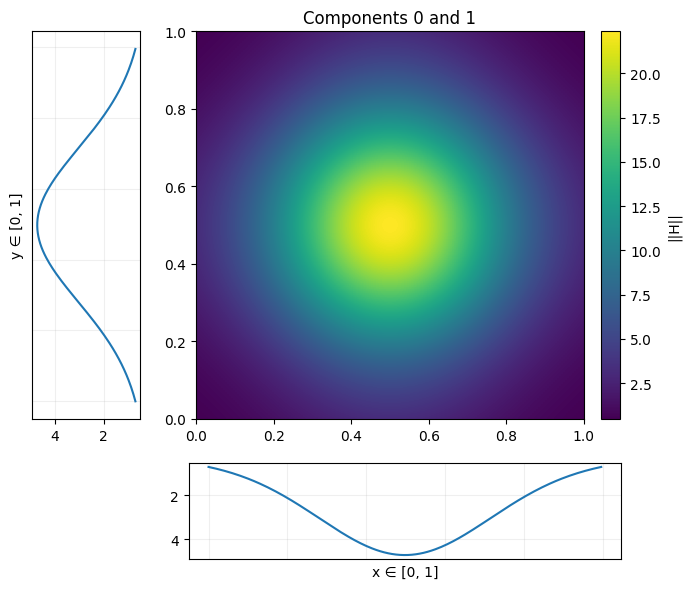

In [2]:
sample_pt = [0.5, 0.5]
fuzzy_sample = fuzzifier._get_gaussian_at_mu_batch(tf.constant(sample_pt))
fuzzy_sample_evaluated = fuzzifier.evaluate_batch(fuzzy_sample)
visualizer = Visualizer(figsize=(7, 6))
visualizer.plot(fuzzy_sample_evaluated, view="magnitude")

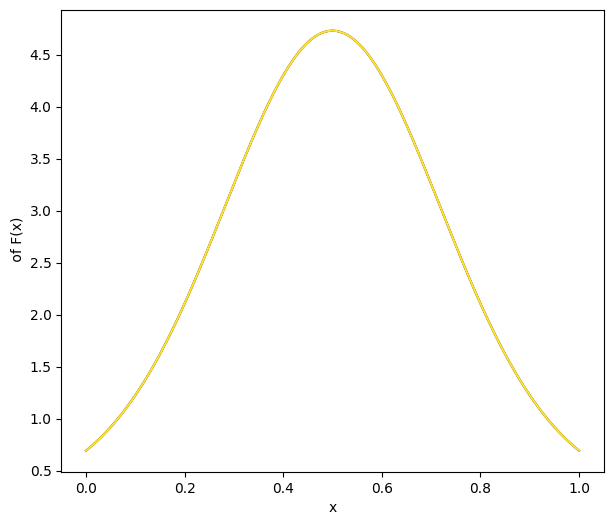

In [3]:
visualizer.plot_rows(fuzzy_sample_evaluated)

# Fuzzy Set Operations

## Config

In [4]:
offset = 0.2
sample_points = [
    [offset, offset],
    [offset, 1-offset],
    [1-offset, offset],
    [1-offset, 1-offset],
]
fuzzy_sample_point_pdfs = [
    fuzzifier._get_gaussian_at_mu_batch(tf.constant(pt))
    for pt in sample_points
]
fuzzy_sample_points = [
    fuzzifier._get_cdf_batch(pt)
    for pt in fuzzy_sample_point_pdfs
]
fuzzy_sample_point_pdfs_evaluated = [
    fuzzifier.evaluate_batch(pt, resolution=100)
    for pt in fuzzy_sample_point_pdfs
]
fuzzy_sample_points_evaluated = [
    fuzzifier.evaluate_batch(pt, resolution=100)
    for pt in fuzzy_sample_points
]

visualizer = Visualizer(figsize=(5, 4))

## Fuzzified PDFs
Probability Density Distributions (PDFs) associated with different samples' fuzzified representations

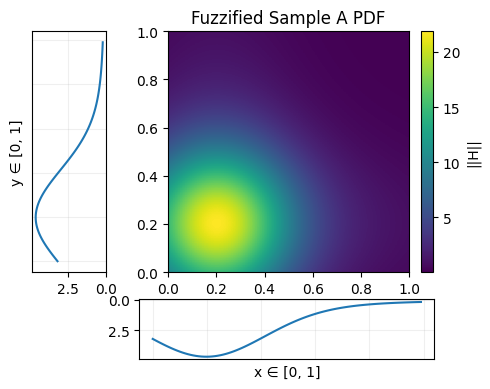

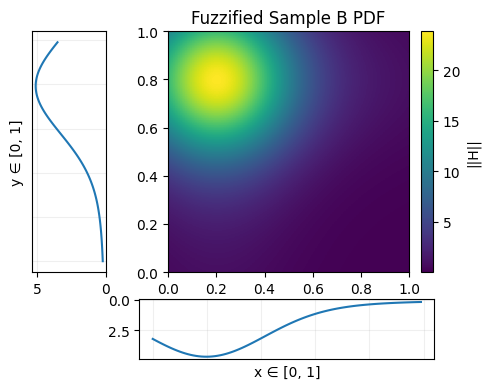

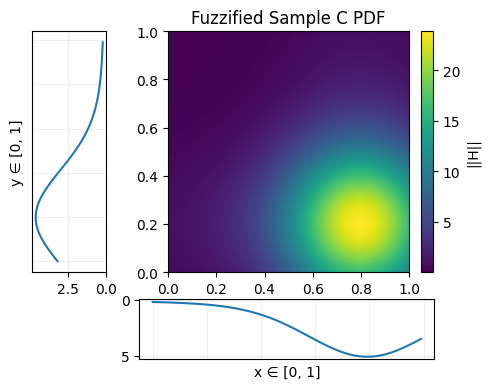

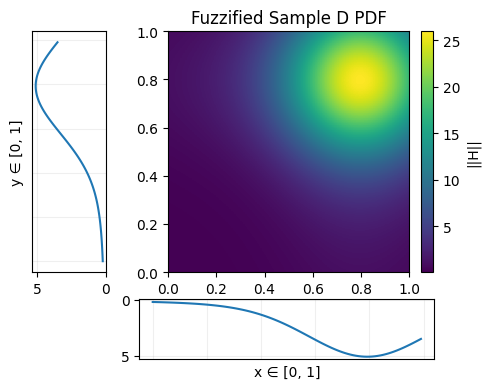

In [5]:
for letter, pt in zip(["A", "B", "C", "D"], fuzzy_sample_point_pdfs_evaluated):
    visualizer.plot(
        pt,
        view="magnitude",
        marginals=True,
        title=f"Fuzzified Sample {letter} PDF"
    )

## Fuzzified Samples' Fuzzy Sets

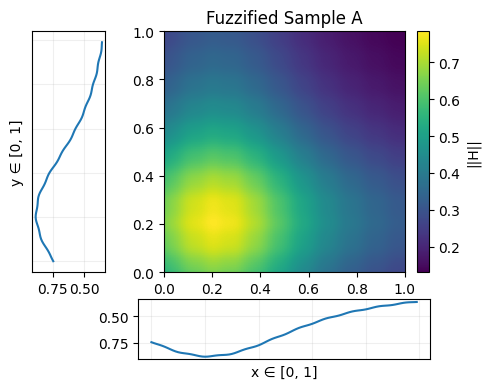

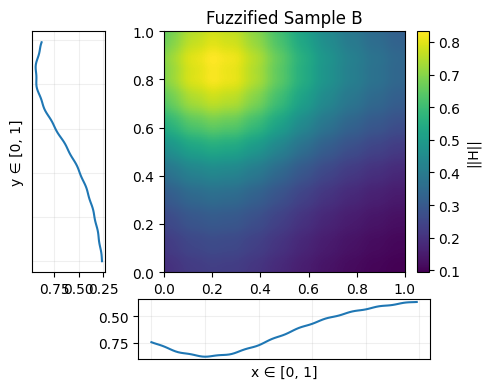

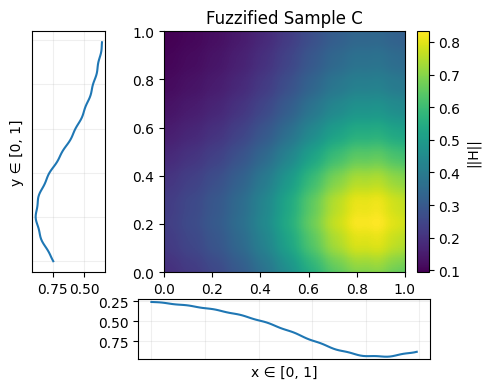

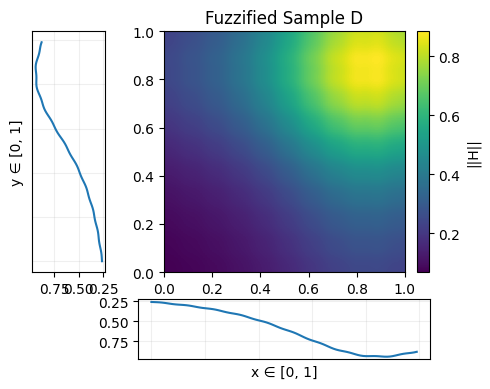

In [6]:
for letter, pt in zip(["A", "B", "C", "D"], fuzzy_sample_points_evaluated):
    visualizer.plot(
        pt,
        view="magnitude",
        marginals=True,
        title=f"Fuzzified Sample {letter}"
    )

## Negation

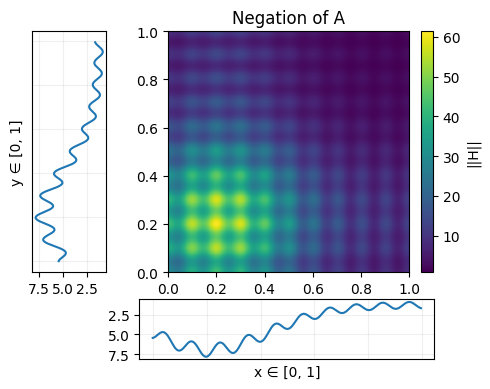

In [7]:
neg_a = fuzzifier.negation_batch(fuzzy_sample_point_pdfs[0])
neg_a_evaluated = fuzzifier.evaluate_batch(neg_a)
visualizer.plot(
    neg_a_evaluated,
    view="magnitude",
    marginals=True,
    title="Negation of A"
)

## Union

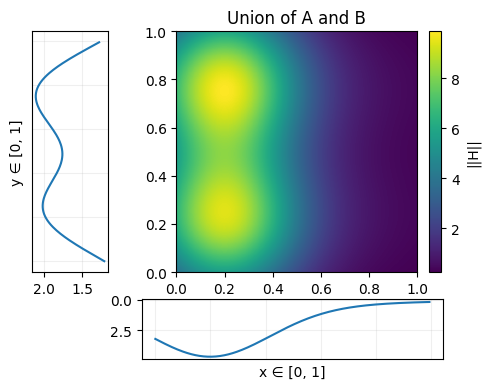

In [8]:
a_u_b = fuzzifier.union_batch(fuzzy_sample_point_pdfs[0], fuzzy_sample_point_pdfs[1])
a_u_b_evaluated = fuzzifier.evaluate_batch(a_u_b)
visualizer.plot(
    a_u_b_evaluated,
    view="magnitude",
    marginals=True,
    title="Union of A and B"
)

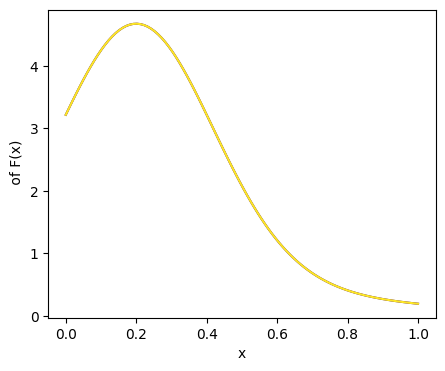

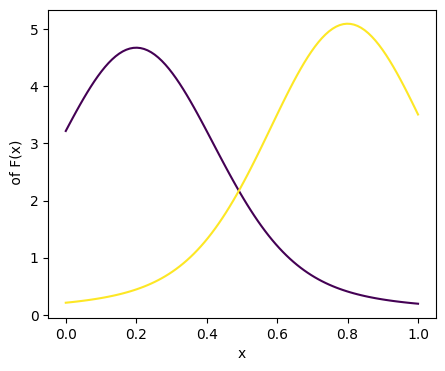

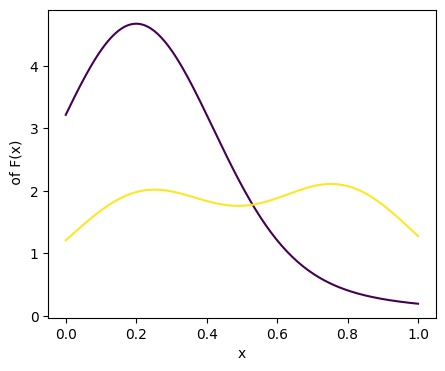

In [9]:
visualizer.plot_rows(fuzzy_sample_point_pdfs_evaluated[0])
visualizer.plot_rows(fuzzy_sample_point_pdfs_evaluated[1])
visualizer.plot_rows(a_u_b_evaluated)

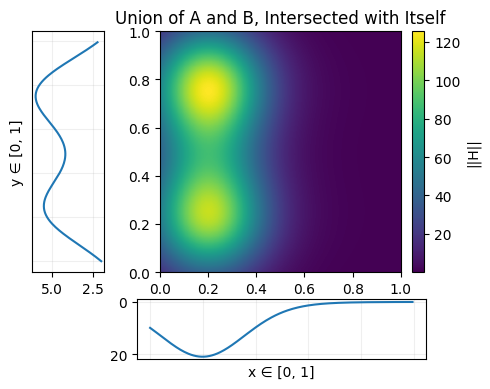

In [10]:
a_u_b_n = fuzzifier.intersection_batch(a_u_b, a_u_b)
a_u_b_n_evaluated = fuzzifier.evaluate_batch(a_u_b_n)
visualizer.plot(
    a_u_b_n_evaluated,
    view="magnitude",
    marginals=True,
    title="Union of A and B, Intersected with Itself"
)

## Intersection

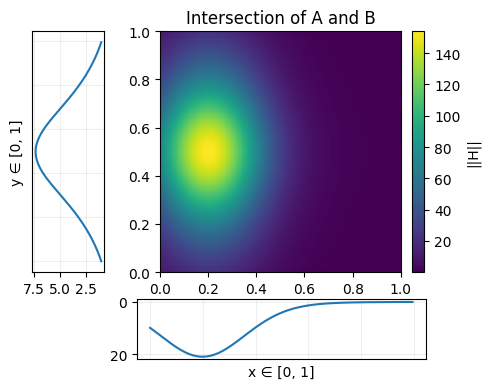

In [11]:
a_n_b = fuzzifier.intersection_batch(fuzzy_sample_point_pdfs[0], fuzzy_sample_point_pdfs[1])
a_n_b_evaluated = fuzzifier.evaluate_batch(a_n_b)
visualizer.plot(
    a_n_b_evaluated,
    view="magnitude",
    marginals=True,
    title="Intersection of A and B"
)

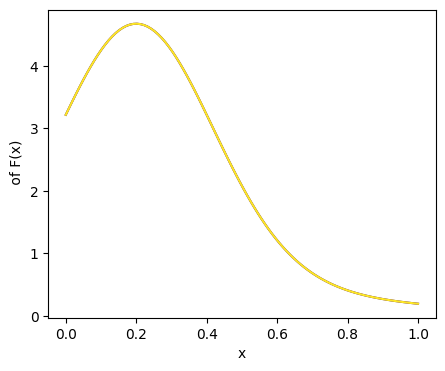

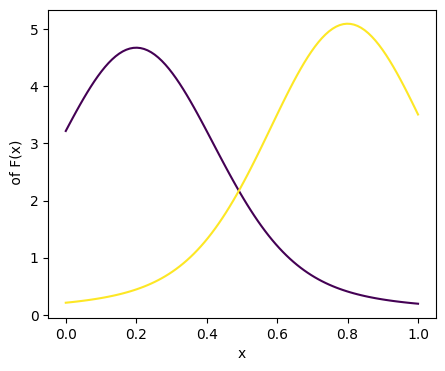

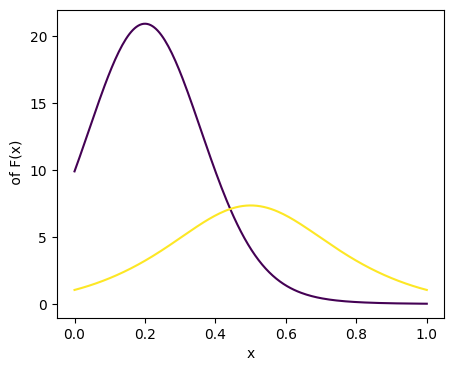

In [12]:
visualizer.plot_rows(fuzzy_sample_point_pdfs_evaluated[0])
visualizer.plot_rows(fuzzy_sample_point_pdfs_evaluated[1])
visualizer.plot_rows(a_n_b_evaluated)

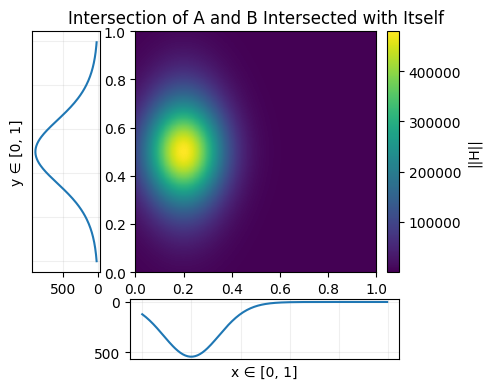

In [13]:
a_n_b_n = fuzzifier.intersection_batch(a_n_b, a_n_b)
a_n_b_n_evaluated = fuzzifier.evaluate_batch(a_n_b_n)
visualizer.plot(
    a_n_b_n_evaluated,
    view="magnitude",
    marginals=True,
    title="Intersection of A and B Intersected with Itself"
)

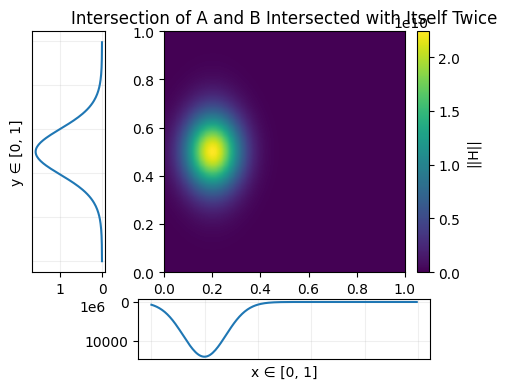

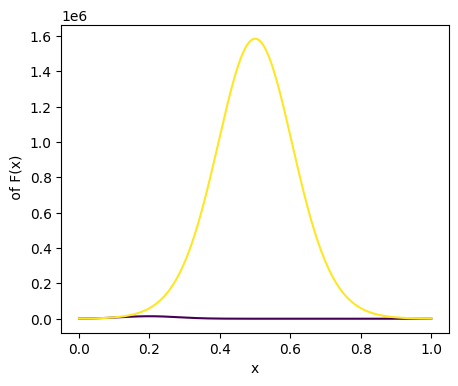

In [14]:
a_n_b_n_n = fuzzifier.intersection_batch(a_n_b_n, a_n_b_n)
a_n_b_n_n_evaluated = fuzzifier.evaluate_batch(a_n_b_n_n)
visualizer.plot(
    a_n_b_n_n_evaluated,
    view="magnitude",
    marginals=True,
    title="Intersection of A and B Intersected with Itself Twice"
)
visualizer.plot_rows(a_n_b_n_n_evaluated)

Intersection of a and b intersected with c:


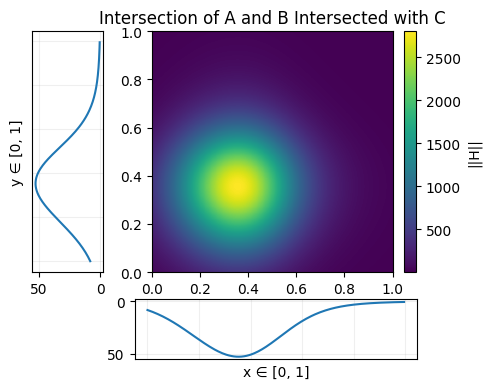

In [15]:
print("Intersection of a and b intersected with c:")
a_n_b_n_c = fuzzifier.intersection_batch(a_n_b, fuzzy_sample_point_pdfs[2])
a_n_b_n_c_evaluated = fuzzifier.evaluate_batch(a_n_b_n_c)
visualizer.plot(
    a_n_b_n_c_evaluated,
    view="magnitude",
    marginals=True,
    title="Intersection of A and B Intersected with C"
)

## Limitations of using only 1D marginal distributions
2 different distributions could have the same union and intersection.

This results in confusion between component distributions and makes the set ops 1-way.

If pairwise marginals were used, though, this issue would be solved for 2D slices but persist for higher-dimensional distributions' composition

### Union

Union of fuzzy sample a (bottom-left) with fuzzy sample d (top-right):


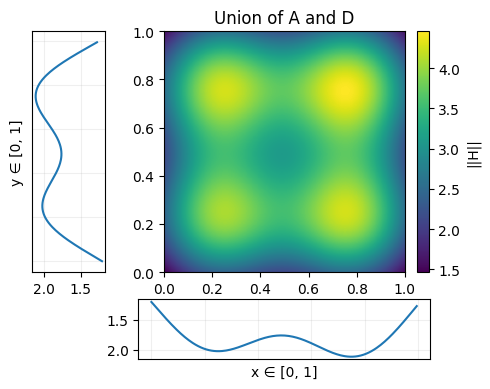

Union of fuzzy sample b (top-left) with fuzzy sample c (bottom-right):


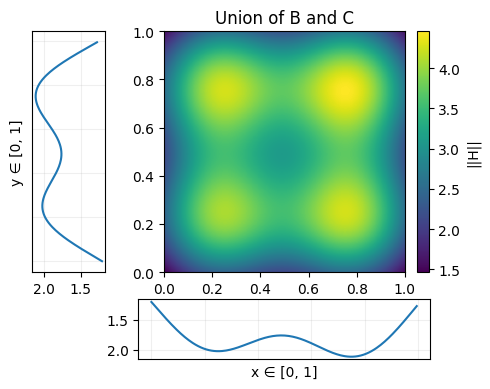

In [16]:
a_u_d = fuzzifier.union_batch(fuzzy_sample_point_pdfs[0], fuzzy_sample_point_pdfs[3])
a_u_d_evaluated = fuzzifier.evaluate_batch(a_u_d)
print("Union of fuzzy sample a (bottom-left) with fuzzy sample d (top-right):")
visualizer.plot(
    a_u_d_evaluated,
    view="magnitude",
    marginals=True,
    title="Union of A and D"
)

b_u_c = fuzzifier.union_batch(fuzzy_sample_point_pdfs[1], fuzzy_sample_point_pdfs[2])
b_u_c_evaluated = fuzzifier.evaluate_batch(b_u_c)
print("Union of fuzzy sample b (top-left) with fuzzy sample c (bottom-right):")
visualizer.plot(
    b_u_c_evaluated,
    view="magnitude",
    marginals=True,
    title="Union of B and C"
)

### Intersection

Intersection of fuzzy sample a (bottom-left) with fuzzy sample d (top-right):


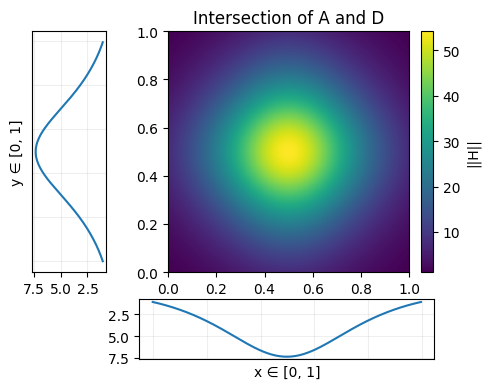

Intersection of fuzzy sample b (top-left) with fuzzy sample c (bottom-right):


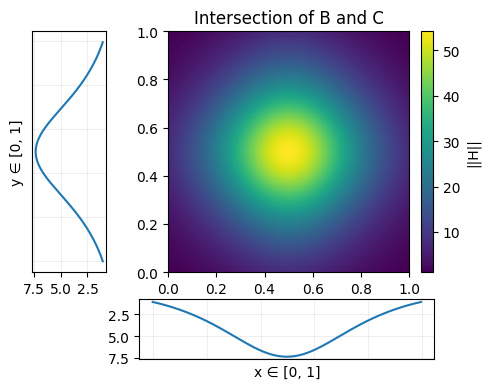

In [17]:
a_n_d = fuzzifier.intersection_batch(fuzzy_sample_point_pdfs[0], fuzzy_sample_point_pdfs[3])
a_n_d_evaluated = fuzzifier.evaluate_batch(a_n_d)
print("Intersection of fuzzy sample a (bottom-left) with fuzzy sample d (top-right):")
visualizer.plot(
    a_n_d_evaluated,
    view="magnitude",
    marginals=True,
    title="Intersection of A and D"
)

b_n_c = fuzzifier.intersection_batch(fuzzy_sample_point_pdfs[1], fuzzy_sample_point_pdfs[2])
b_n_c_evaluated = fuzzifier.evaluate_batch(b_n_c)
print("Intersection of fuzzy sample b (top-left) with fuzzy sample c (bottom-right):")
visualizer.plot(
    b_n_c_evaluated,
    view="magnitude",
    marginals=True,
    title="Intersection of B and C"
)